 MAE: 4.0754
 RMSE: 5.4593
 R² Score: 1.0000


C:\Users\santhosh\AppData\Local\Temp\ipykernel_540\406127064.py:67: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


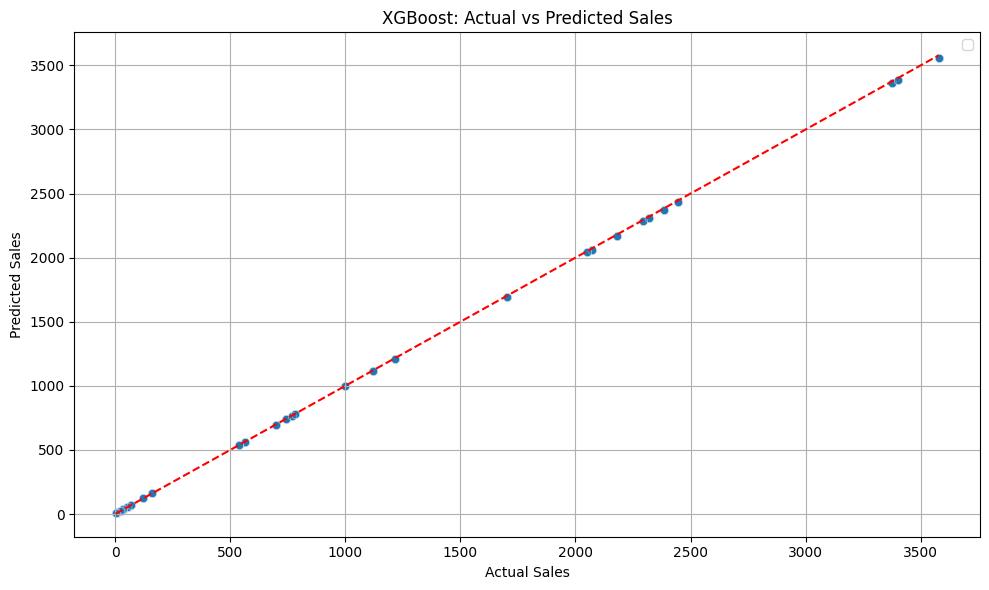

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load Cleaned Data
df = pd.read_csv("../data/cleaned_sales_data.csv")

# Step 2: Convert OrderDate to datetime & Create YearMonth
df['OrderDate'] = pd.to_datetime(df['OrderDate'])
df['YearMonth'] = df['OrderDate'].dt.to_period('M').astype(str)

# Step 3: Drop high-cardinality & irrelevant columns
columns_to_drop = [
    'SalesOrderNumber', 'DueDate', 'ShipDate',
    'CustomerKey', 'ProductKey', 'SalesTerritoryKey',
    'CustomerName', 'ProductName', 'ModelName'
]
df.drop(columns=columns_to_drop, axis=1, inplace=True)

# Step 4: Drop datetime columns before encoding
datetime_cols = df.select_dtypes(include=['datetime64', 'datetime64[ns]']).columns
df.drop(columns=datetime_cols, inplace=True)

# Step 5: One-Hot Encode remaining categorical features
df_encoded = pd.get_dummies(df, drop_first=True)

# Step 6: Define Features (X) and Target (y)
X = df_encoded.drop('SalesAmount', axis=1)
y = df_encoded['SalesAmount']

# Step 7: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 8: Scale Numeric Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 9: Train XGBoost Regressor
model = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=6, random_state=42)
model.fit(X_train_scaled, y_train)

# Step 10: Predict
y_pred = model.predict(X_test_scaled)

# Step 11: Evaluate Model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f" MAE: {mae:.4f}")
print(f" RMSE: {rmse:.4f}")
print(f" R² Score: {r2:.4f}")

# Step 12: Visualization - Actual vs Predicted
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("XGBoost: Actual vs Predicted Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [3]:
# Export Predictions to Power BI (with Month)

# Add Month back to the original dataframe (before encoding)
df_original = pd.read_csv("../data/cleaned_sales_data.csv")
df_original['OrderDate'] = pd.to_datetime(df_original['OrderDate'])
df_original['Month'] = df_original['OrderDate'].dt.to_period('M').astype(str)
df_original = df_original.drop_duplicates(subset=['SalesAmount'])  # Avoid mismatches in shape

# Convert test set back to DataFrame
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# Add predictions and actual values
X_test_df['ActualSales'] = y_test.values
X_test_df['PredictedSales'] = y_pred

# Add Month column (optional merge if needed)
X_test_df = pd.concat([X_test_df.reset_index(drop=True), df_original[['Month']].reset_index(drop=True)], axis=1)

# Reorder columns
cols = ['Month', 'ActualSales', 'PredictedSales'] + [col for col in X_test_df.columns if col not in ['Month', 'ActualSales', 'PredictedSales']]
X_test_df = X_test_df[cols]

# Export to CSV for Power BI
X_test_df.to_csv("../visualization/XGBoost_sales_forecast.csv", index=False)
print(" Exported XGBoost predictions to: sales_predictions.csv")


 Exported XGBoost predictions to: sales_predictions.csv


In [15]:
# Check some values
comparison = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": y_pred
})
print(comparison.head(10))


      Actual    Predicted
0     4.9900     7.851311
1     7.9500    10.785355
2    34.9900    37.661030
3    34.9900    37.661030
4    24.4900    27.226730
5    53.9900    56.540916
6    53.9900    56.540916
7     4.9900     7.851311
8     4.9900     7.851311
9  2071.4196  2061.901123


Text(0.5, 1.0, 'XGBoost: Actual vs Predicted Scatter')

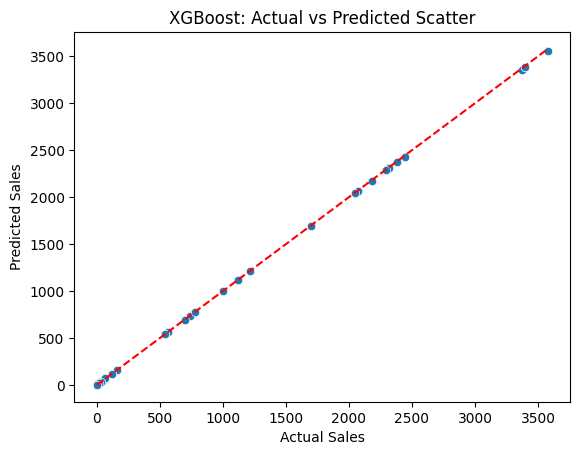

In [9]:
import seaborn as sns
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("XGBoost: Actual vs Predicted Scatter")


In [12]:
# 📍 File: xgboost_forecast_final.py or .ipynb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

# ------------------ Step 1: Load Data ------------------
df = pd.read_csv("../data/cleaned_sales_data.csv")  # Update path if needed

# ------------------ Step 2: Add Month Column ------------------
df['OrderDate'] = pd.to_datetime(df['OrderDate'])
df['Month'] = df['OrderDate'].dt.to_period('M').astype(str)

# ------------------ Step 3: Drop Unnecessary Columns ------------------
columns_to_drop = [
    'SalesOrderNumber', 'DueDate', 'ShipDate',
    'CustomerKey', 'ProductKey', 'SalesTerritoryKey',
    'CustomerName', 'ProductName', 'ModelName', 'OrderDate'
]
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# ------------------ Step 4: One-Hot Encode Useful Categorical Columns ------------------
categorical_cols = ['Gender', 'MaritalStatus', 'ProductLine', 'SalesTerritoryCountry', 'SalesTerritoryRegion', 'EnglishMonthName']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# ------------------ Step 5: Define Features and Target ------------------
X = df_encoded.drop(['SalesAmount', 'Month'], axis=1, errors='ignore')
y = df_encoded['SalesAmount']

# Drop any remaining object-type columns from X (safety check)
X = X.select_dtypes(include=[np.number])

# ------------------ Step 6: Train-Test Split ------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ------------------ Step 7: Scale Features ------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ------------------ Step 8: Train XGBoost Model ------------------
model = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=6, random_state=42)
model.fit(X_train_scaled, y_train)

# ------------------ Step 9: Predict and Evaluate ------------------
y_pred = model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Model Performance")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

Model Performance
MAE: 4.08
RMSE: 5.46
R²: 1.00


In [14]:

# ------------------ Step 10: Export to Power BI ------------------

# Load original Month info
df_months = df[['Month']].iloc[y_test.index].reset_index(drop=True)

# Create export DataFrame
X_test_export = pd.DataFrame({
    'Month': df_months['Month'],
    'ActualSales': y_test.values,
    'PredictedSales': y_pred
})

# Save to CSV
X_test_export.to_csv("../visualization/New_XGBoost_sales_forecast.csv", index=False)
print(" Exported: XGBoost_sales_forecast_fixed.csv")


 Exported: XGBoost_sales_forecast_fixed.csv
